# Evaluation of Classifiers on Data Other than the Bioreactor Samples

This notebook analyzes the accuracy of the SVM classifier on data other than the bioreactor samples.
The analysis makes use of data built by ClassificationData in the tools directory.
This class augments the global namespace to include data used in analysis.

The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# TO DO
1. **Check calculation of pooled, whether average log**
1. Structure codes for the analyses conducted. This structure should be reflected in ``DATA_DCT``.
   1. Selection of genes: myco, myco +, all genes
   1. How counts are processed
      1. Reference - T0/biostat, T0/data source, pooled/data source
1. Evaluation of classifiers
   1. Performance on biostat data
   1. Performance on other samples
      1. Time consistency
      1. Replication consistency
      1. Consistency with expectation
1. Analyses for Eliza:
   1. Accuracy with all 11 and the accuracy as you add in more genes (same as what you just sent but with all 11).
   1. Could you test with just the 10 mycobactin genes (Rv2377c-Rv2386c)?
   1. Could you test with just bacterioferritin (Rv3841)? Just Rv2384?
   1. Is there one gene that gives good accuracy
1. compare accuracy with ranom selection of genes
1. Classifier coefficient profile.
   1. Eliza genes - 1-10
   1. Auto selected genes: 5, 10, 20

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common_python.util import dataframe
from tools import make_classification_data

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

In [2]:
data = make_classification_data.ClassificationData()
data.get(globals())

## Constants

In [43]:
FULL_RUN = False

STAGES = list(cn.STATE_NAMES)
STAGES.remove("Normoxia")

['Transition', 'Stage1a', 'Stage1b', 'StageII', 'Resuscitation']

## Helper Functions

In [4]:
def plotSampleData(data_dct, genes= None, is_plot=True):
    """
    Plots trinary values of data for the specified genes.
    
    Parameters
    ----------
    data_dct: dict
        key: reference type
        value: sample dictionary
            key: sample name
            value: features
    genes: list-str
    """
    ref_types = list(data_dct.keys())
    sample_names = list(data_dct[ref_types[0]].keys())
    for sample_name in sample_names:
        for ref_type in ref_types:
            df_X = data_dct[ref_type][sample_name]
            if genes is None:
                genes = list(df_X.columns)
            TRINARY.plotExpressionLevels(genes, df_X=df_X, title=ref_type + ", " + sample_name, is_plot=is_plot)
            
# Tests
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES, is_plot=False)
print("OK!")

OK!


In [5]:
def reportSamplePredictions(data_dct):
    for name, df_X in data_dct.items():
        print("\n%s" % name)
        df_pred = CLASSIFIER.predict(df_X)
        new_columns = [STAGE_NAMES[c] for c in df_pred.columns]
        df_pred.columns = new_columns
        print(df_pred)

## Gene Expression

**Observations**
1. Prefer control values that avoid having a constant value of the trinary value over the samples (since such a situation is unhelpful for distinguishing classes).
1. On training data (Bioreactor)
   1. Many genes have the same within class values
   1. Few genes have the same between class values

**TO DO**: Plot data in pairs, 1 column, 2 rows; this allows comparisons of the expressions for T0 vs. pooled.

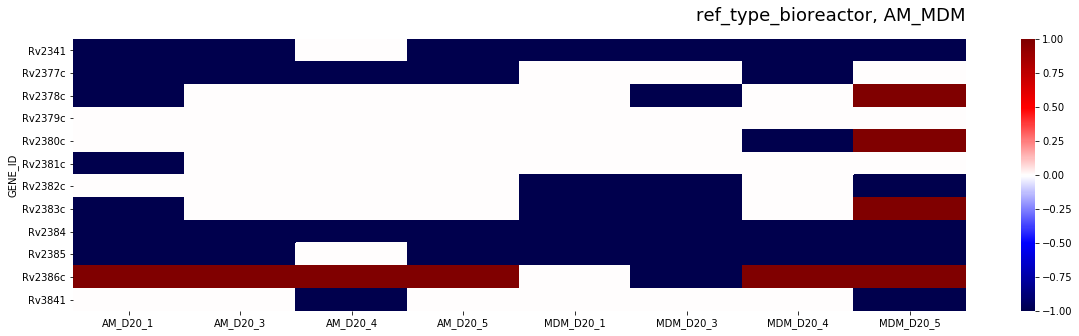

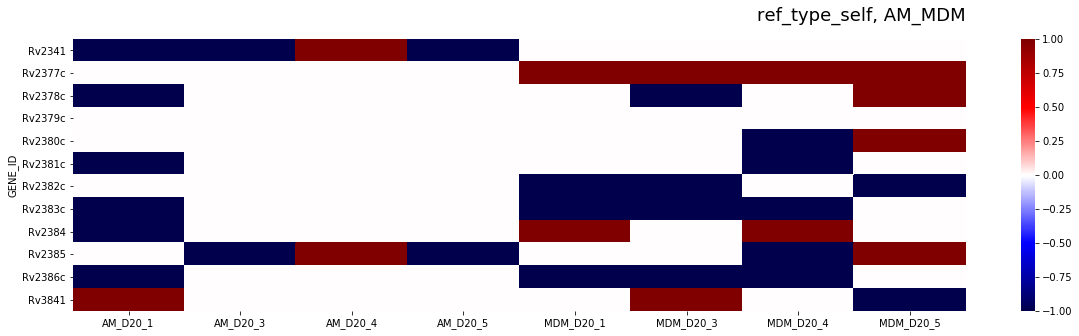

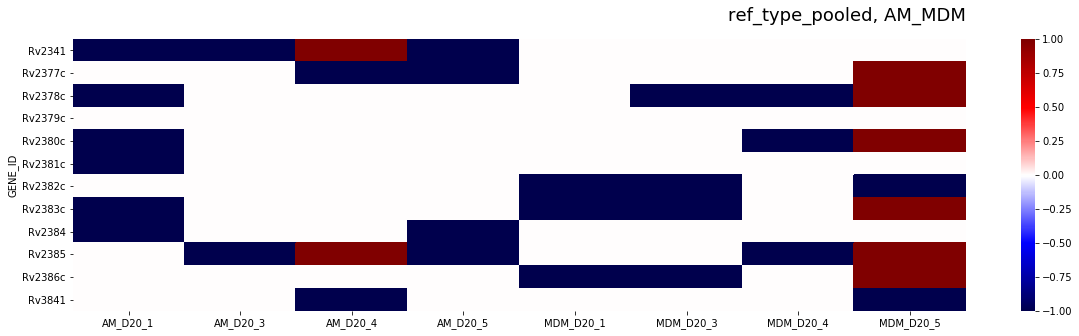

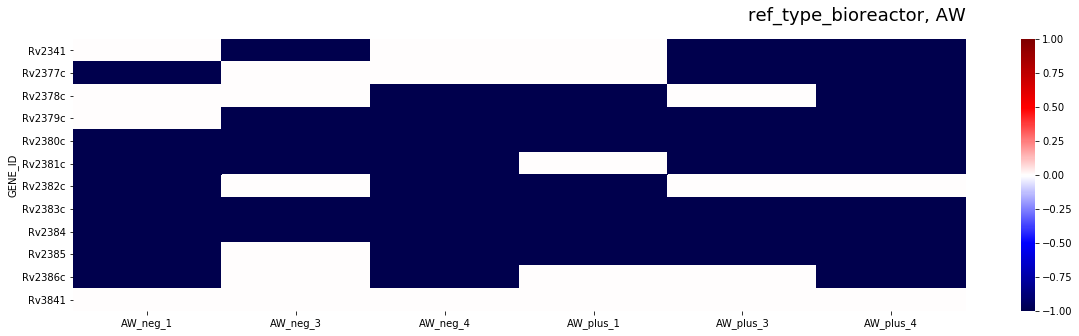

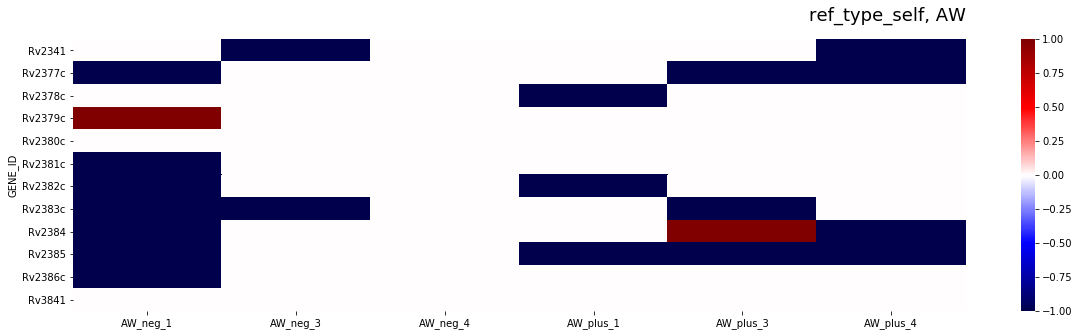

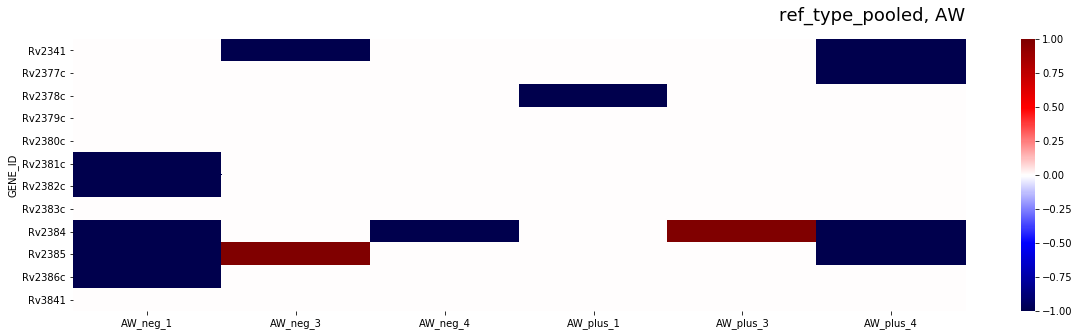

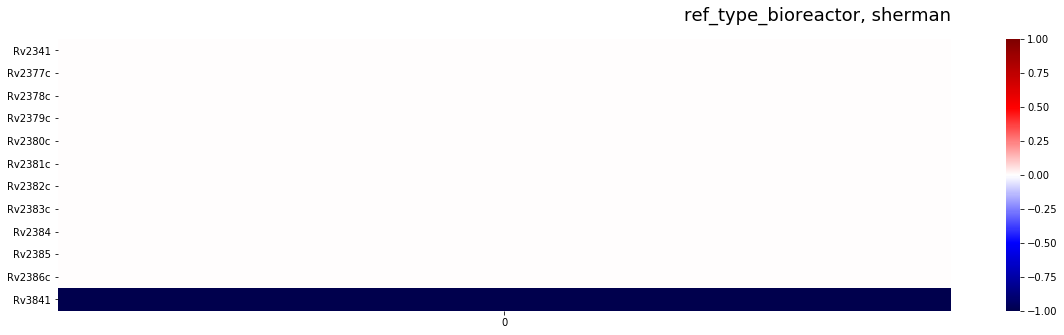

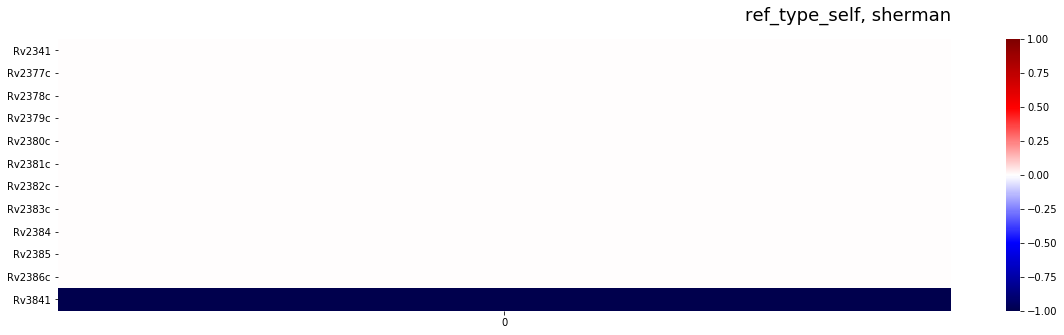

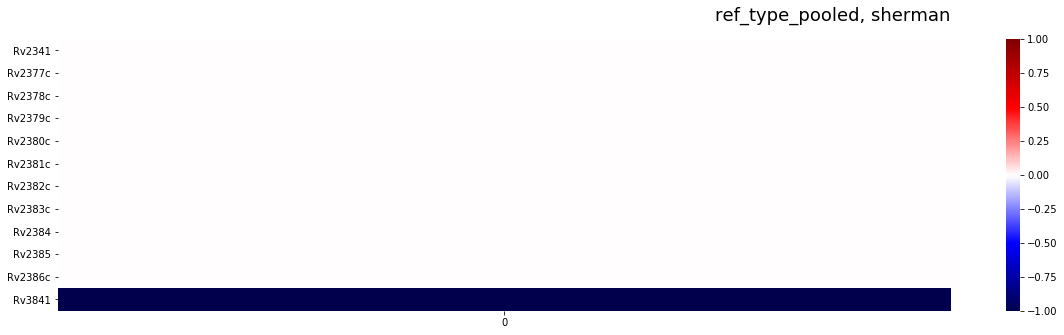

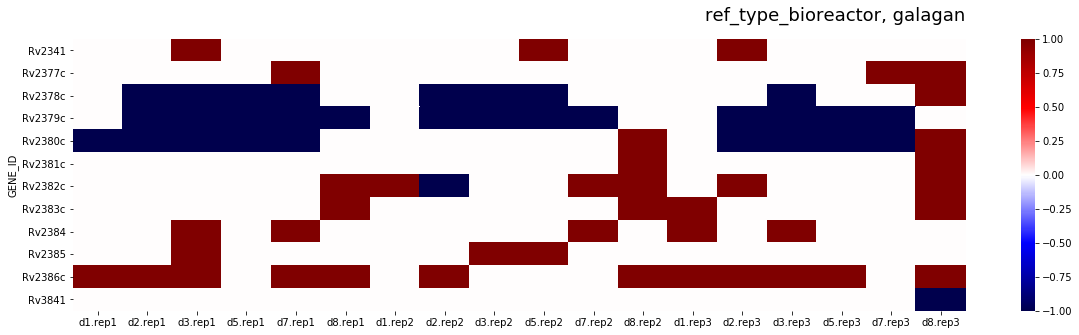

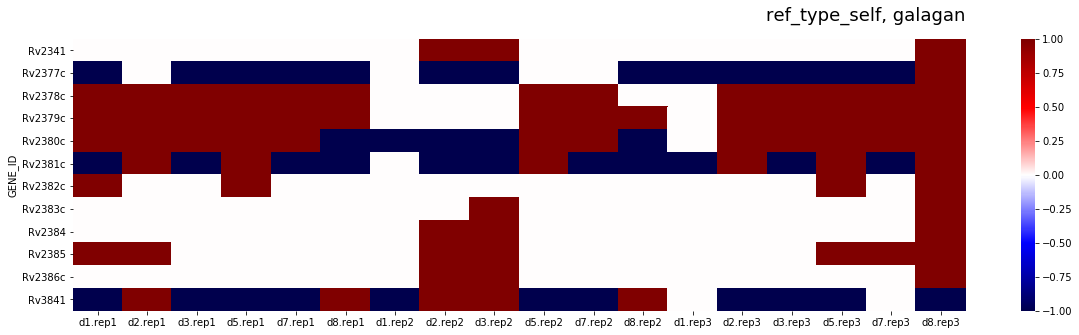

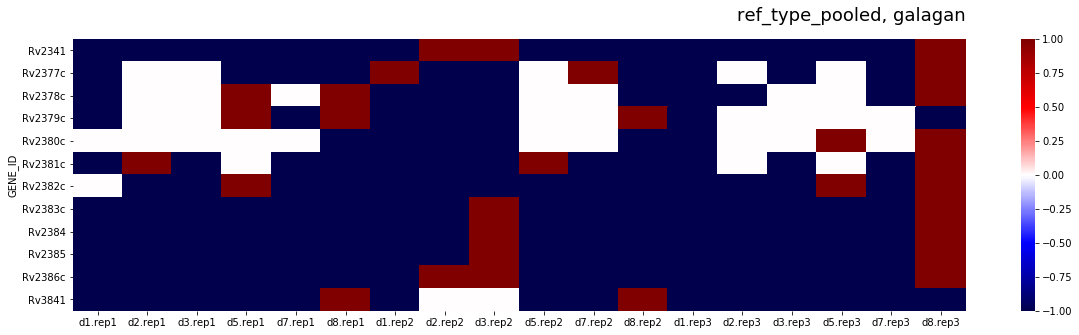

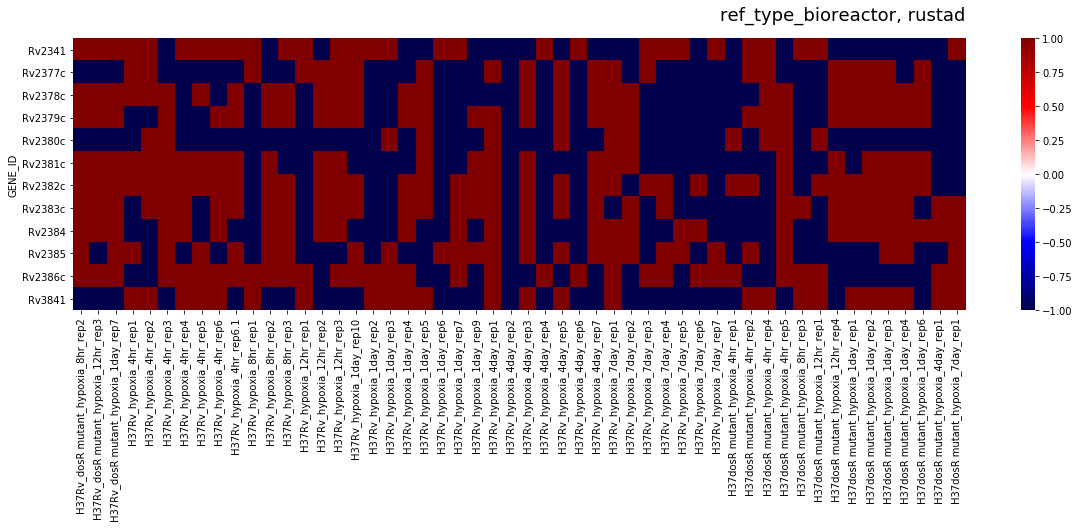

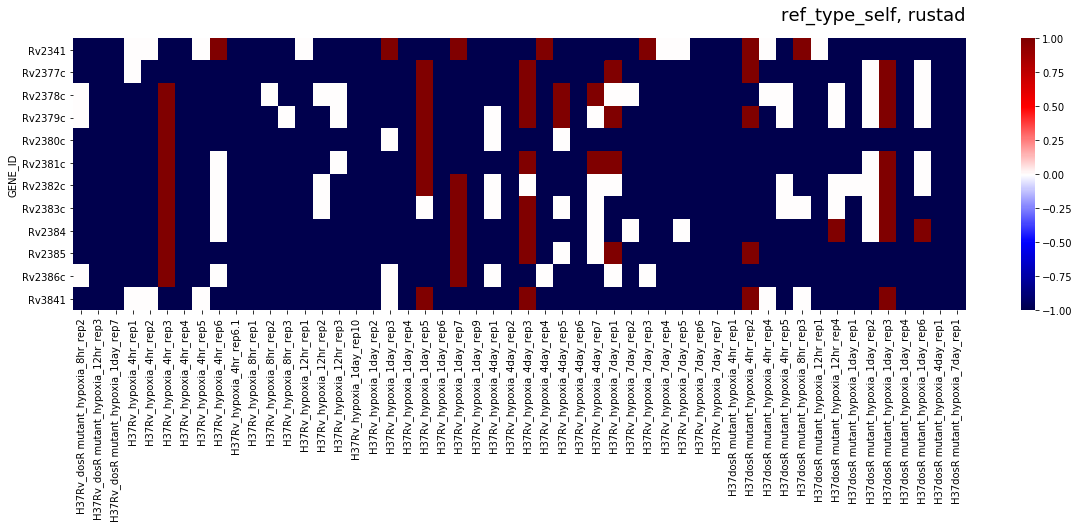

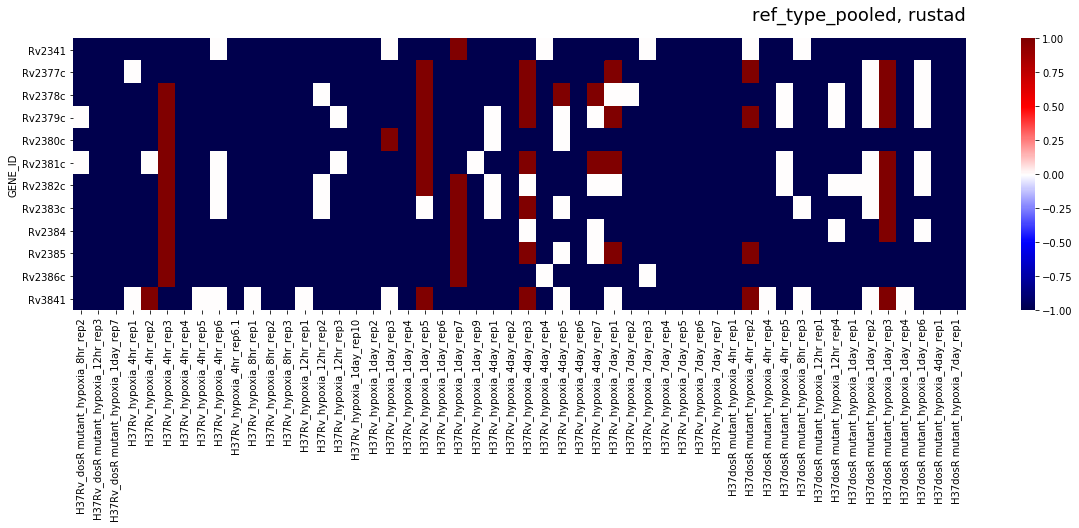

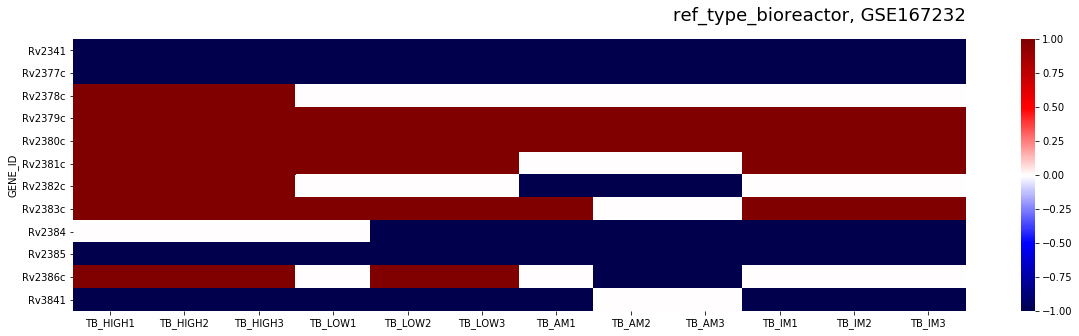

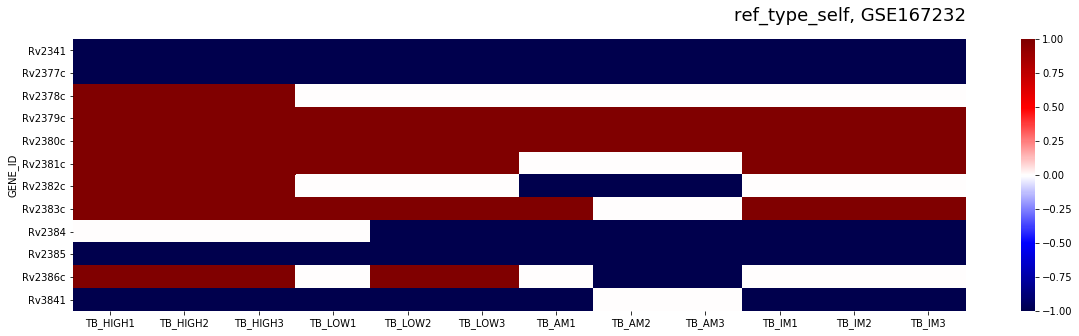

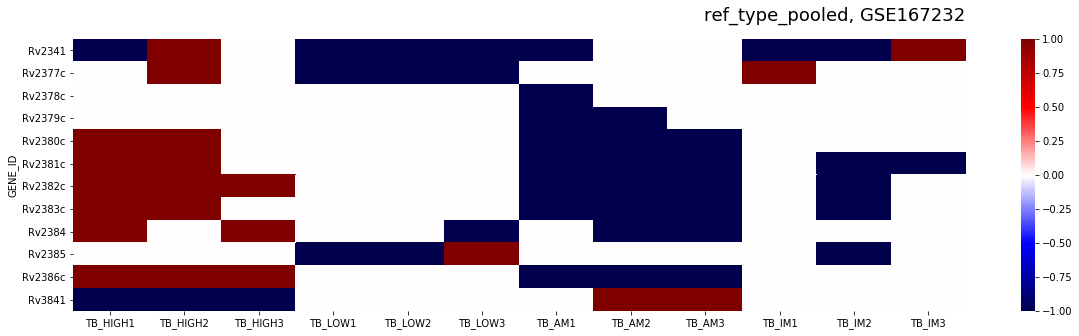

In [6]:
# With Bioreactor reference data
plotSampleData(SAMPLE_DCT, genes=MYCOBACTIN_BACTERIOFERRIN_GENES)

# Conditions Analysis

Compare the predictions of conditions (with different sized markers)?

## AM, MDM

# Classification of Samples

In [7]:
CLASSIFIER.predict(SAMPLE_DATA_DCT["AM_MDM"])

,0,1,2,3,4
AM_D20_1,0.00,0.0,1.00,0.0,0.00
AM_D20_3,0.01,0.0,0.96,0.0,0.03
AM_D20_4,0.00,0.0,1.00,0.0,0.00
AM_D20_5,0.01,0.0,0.96,0.0,0.03
MDM_D20_1,1.00,0.0,0.00,0.0,0.00
MDM_D20_3,1.00,0.0,0.00,0.0,0.00
MDM_D20_4,0.00,0.0,1.00,0.0,0.00
MDM_D20_5,0.89,0.0,0.00,0.0,0.11


In [8]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_BIOREACTOR])


AM_MDM
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AM_D20_1         0.00      0.0     1.00      0.0           0.00
AM_D20_3         0.01      0.0     0.96      0.0           0.03
AM_D20_4         0.00      0.0     1.00      0.0           0.00
AM_D20_5         0.01      0.0     0.96      0.0           0.03
MDM_D20_1        1.00      0.0     0.00      0.0           0.00
MDM_D20_3        1.00      0.0     0.00      0.0           0.00
MDM_D20_4        0.00      0.0     1.00      0.0           0.00
MDM_D20_5        0.89      0.0     0.00      0.0           0.11

AW
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AW_neg_1          1.0      0.0      0.0      0.0            0.0
AW_neg_3          0.0      0.0      1.0      0.0            0.0
AW_neg_4          1.0      0.0      0.0      0.0            0.0
AW_plus_1         1.0      0.0      0.0      0.0            0.0
AW_plus_3         0.0      0.0      1.0      0.0            0.0
AW_plus_4         1.0      0

In [9]:
reportSamplePredictions(SAMPLE_DCT[REF_TYPE_POOLED])


AM_MDM
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AM_D20_1         0.01      0.0     0.99     0.00           0.00
AM_D20_3         0.87      0.0     0.00     0.13           0.00
AM_D20_4         0.04      0.0     0.87     0.03           0.06
AM_D20_5         0.97      0.0     0.00     0.00           0.03
MDM_D20_1        1.00      0.0     0.00     0.00           0.00
MDM_D20_3        1.00      0.0     0.00     0.00           0.00
MDM_D20_4        0.00      0.0     0.00     1.00           0.00
MDM_D20_5        0.00      1.0     0.00     0.00           0.00

AW
           Transition  Stage1a  Stage1b  StageII  Resuscitation
AW_neg_1         1.00     0.00      0.0      0.0           0.00
AW_neg_3         0.06     0.94      0.0      0.0           0.00
AW_neg_4         1.00     0.00      0.0      0.0           0.00
AW_plus_1        0.00     0.00      0.0      1.0           0.00
AW_plus_3        0.00     0.00      0.0      1.0           0.00
AW_plus_4        0.97     0.

# Condition Analysis

Analyzes data sets with distinct conditions.

In [29]:
prediction_df

,0,1,2,3,4
AM_D20_1,0.00,0.0,0.96,0.04,0.0
AM_D20_3,0.00,0.0,1.00,0.00,0.0
AM_D20_4,0.00,0.0,1.00,0.00,0.0
AM_D20_5,0.00,0.0,1.00,0.00,0.0
MDM_D20_1,0.93,0.0,0.07,0.00,0.0
MDM_D20_3,0.96,0.0,0.04,0.00,0.0
MDM_D20_4,0.00,0.0,0.03,0.97,0.0
MDM_D20_5,0.96,0.0,0.04,0.00,0.0


In [42]:
cn.STATE_NAMES

['Normoxia', 'Transition', 'Stage1a', 'Stage1b', 'StageII', 'Resuscitation']

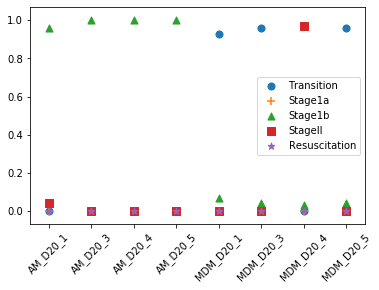

In [54]:
conditionFunc = lambda v: v[0:3].replace("_", "")
def plotConditionPrediction(clf, df_X, conditionFunc, state_names=STAGES): 
    indices = df_X.index
    indices = sorted(list(indices), key=conditionFunc)
    newdf_X = df_X.copy()
    newdf_X.index = indices
    prediction_df = clf.predict(newdf_X)
    _, ax = plt.subplots(1)
    markers = ["o", "+", "^", "s", "*"]
    for idx, stage in enumerate(prediction_df.columns):
        ax.scatter(indices, prediction_df[stage], marker=markers[idx], s=50)
        ax.set_xticklabels(indices, rotation=45)
    ax.legend(state_names)
    return prediction_df
    
prediction_df = plotConditionPrediction(CLASSIFIER_DCT[(T0, "all")], df, conditionFunc)

In [ ]:
clf = CLASSIFIER_DCT[(T0, "all")]
df_X = SAMPLE_DCT[REF_TYPE_BIOREACTOR]["AM_MDM"]
conditionFunc = lambda v: v[0:3].replace("_", "")
plotConditions(self, clf, df_X, conditionFunc, state_names=STAGE_NAMES)

In [40]:
cn.STATE_DCT

AttributeError: module 'common.constants' has no attribute 'STATE_DCT'

# Progression Analysis

## GSE167232

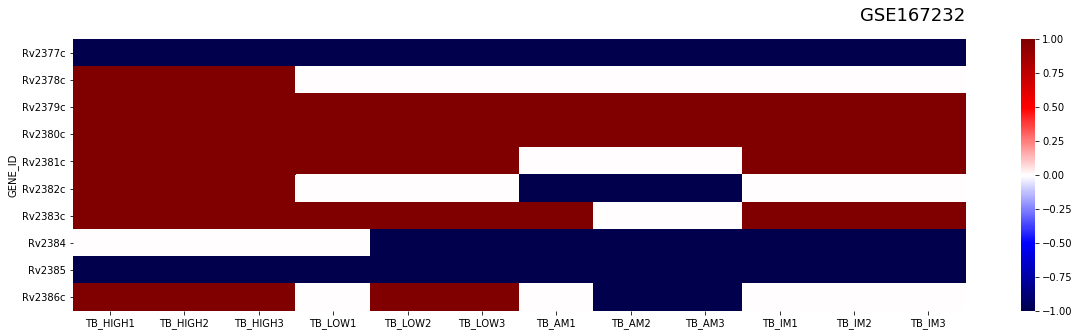

In [13]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DATA_DCT["GSE167232"], title="GSE167232")

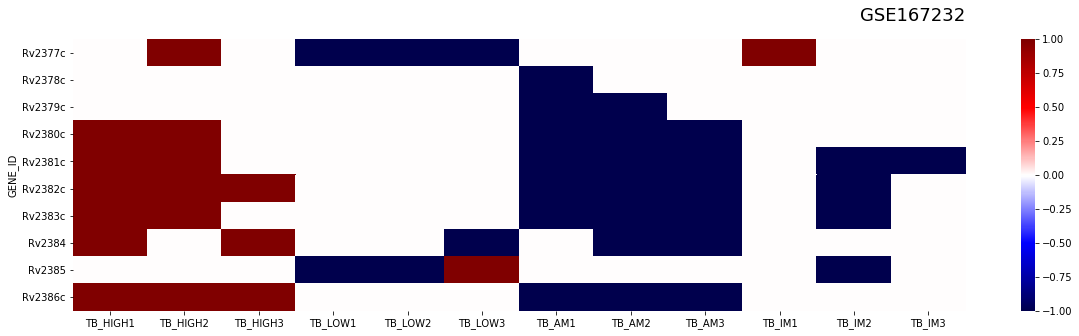

In [14]:
TRINARY.plotExpressionLevels(CLASSIFIER.features, df_X=SAMPLE_DCT[REF_TYPE_POOLED]["GSE167232"], title="GSE167232")

In [15]:
#CLASSIFIER.plotFeatureContributions(df_X.loc["TB_AM1",:], class_names=STAGE_NAMES)
if FULL_RUN:
    df_predict = CLASSIFIER.predict(SAMPLE_DATA_DCT["GSE167232"])
    indexArr = np.reshape(list(df_predict.index), (4,3))
    num_row = 4
    num_col =3
    _, axes = plt.subplots(num_row, num_col, figsize=(20, 12))
    for irow in range(4):
        for icol in range(3):
            if icol == 0:
                is_ylabel = True
            else:
                is_ylabel = False
            if icol == num_col - 1:
                is_legend = True
            else:
                is_legend = False
            if irow == num_row - 1:
                is_xlabel = True
            else:
                is_xlabel = False
            instance = indexArr[irow, icol]
            ser_X = SAMPLE_DATA_DCT["GSE167232"].loc[instance, :]
            CLASSIFIER.plotFeatureContributions(ser_X, class_names=STAGE_NAMES, title=instance, ax=axes[irow,icol], is_plot=False,
                                               is_xlabel=is_xlabel, is_ylabel=is_ylabel, is_legend=is_legend)
    plt.show()

In [16]:
CLASSIFIER_DCT.keys()

dict_keys([('T0', 'mycobactin'), ('T0', 'bacterioferritin'), ('T0', 'mycobactin_bacterioferritin'), ('T0', 'all'), ('pooled', 'mycobactin'), ('pooled', 'bacterioferritin'), ('pooled', 'mycobactin_bacterioferritin'), ('pooled', 'all')])

In [17]:
SAMPLE_DCT.keys()

dict_keys(['ref_type_bioreactor', 'ref_type_self', 'ref_type_pooled'])

## Rustad

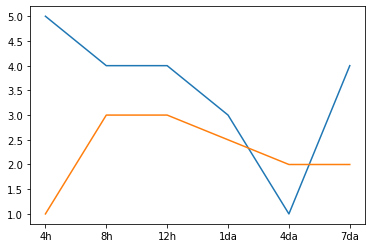

In [18]:
x_vals = ['4h', '8h', '12h', '1da', '4da', '7da']
y_vals = [5, 4, 4, 3, 1, 4]
plt.plot(x_vals, y_vals)
x_vals = ['4h', '8h', '12h', '4da', '7da'] 
y_vals = [1, 3, 3, 2, 2]
plt.plot(x_vals, y_vals)

AttributeError: 'ClassifierEnsemble' object has no attribute 'plotReplicationsOverTime'

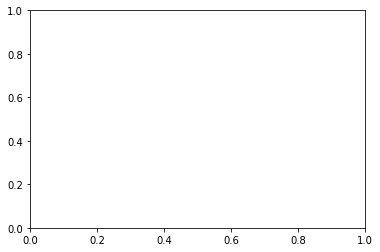

In [19]:
if True:
    for clf_key, clf in CLASSIFIER_DCT.items():
        for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
            _, ax = plt.subplots(1)
            df_X = SAMPLE_DCT[ref_type]["rustad"]
            # Select hypoxia samples
            sel =  ["H37Rv_hypoxia" in i and (not "10" in i) for i in df_X.index]
            df_X = df_X[sel]
            # Select just replication 1-3
            sel =  [any([r in i for r in ["rep1", "rep2", "rep3"]])  for i in df_X.index]
            df_X = df_X[sel]
            #
            replFunc = lambda i: i[-4:]
            timeFunc = lambda i: i[-9:-6].replace("_", "")
            #time_strs = ["4hr", "12hr", "1day", "4day", "7day"]
            title = "rustad: " + ref_type + ", " + "--".join(clf_key)
            clf.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

In [ ]:
def calcRustadParameters(feature_ref_type, clf_key):
    """
    Constructs the plot characteristics
    
    Parameters
    ----------
    feature_ref_type: str
    clf_key: (str, str)
    
    Returns
    -------
    df_X: DataFrame (feature vector)
    replFunc: Function (constructs replication strings)
    timeFunc: Function (constructs time strings)
    row_title: str (title for a row of plots)
    plot_title: str (plot title)
    """
    df_X = SAMPLE_DCT[feature_ref_type]["rustad"]
    sel =  ["H37Rv_hypoxia" in i and (not "10" in i) for i in df_X.index]
    df_X = df_X[sel]
    # Select just replication 1-3
    sel =  [any([r in i for r in ["rep1", "rep2", "rep3"]])  for i in df_X.index]
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[-9:-6].replace("_", "")
    plot_title = "--".join(clf_key)
    row_title = "T0" if feature_ref_type == make_classification_data.REF_TYPE_BIOREACTOR else "pooled"
    return df_X[sel], replFunc, timeFunc, row_title, plot_title

# Tests
df_X, replFunc, timeFunc, row_title, plot_title = calcRustadParameters("ref_type_bioreactor", ("T0", "all"))
assert(isinstance(df_X, pd.DataFrame))
assert(isinstance(plot_title, str))

In [ ]:
def plotProgression(func):
    """
    Does line plots for the sample.
    The plot row indicates how data are prepared. The columns indicate how
    the classifier is construted.
    
    Paramters
    ---------
    func: Function
        parameters: ref_type (str)
        returns: df_X, replFunc, timeFunc, title
    """
    ref_types = [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]
    ncol = len(CLASSIFIER_DCT.keys())
    nrow = len(ref_types)
    _, axes = plt.subplots(nrow, ncol, figsize=(12, 10))
    icol = 0
    irow = 0
    for feature_ref_type in ref_types:
        for clf_key, clf in CLASSIFIER_DCT.items():
            ax = axes[irow, icol]
            df_X, replFunc, timeFunc, row_title, plot_title = func(feature_ref_type, clf_key)
            clf.plotReplicationsOverTime(df_X, replFunc, timeFunc, ax=ax, is_plot=False)
            if icol == 0:
                ax.text(-2, 5.5, row_title, fontsize=16)
            else:
                ax.set_yticklabels([])
            if irow == 0:
                ax.set_xticklabels([])
            else:
                plot_title = ""
            ax.set_title(plot_title, rotation=45)
            icol += 1
            if icol >= ncol:
                icol = 0
                irow += 1
    plt.show()
            
plotProgression(calcRustadParameters)

## AM, MDM

In [ ]:
SAMPLE_DATA_DCT["AM_MDM"]

## Galagan

In [ ]:
for ref_type in [REF_TYPE_BIOREACTOR, REF_TYPE_POOLED]:
    df_X = SAMPLE_DCT[ref_type]["galagan"]
    prediction_df = CLASSIFIER.predict(df_X)
    replFunc = lambda i: i[-4:]
    timeFunc = lambda i: i[0:2]
    title = "galagan: " + ref_type
    _, ax = plt.subplots(1)
    CLASSIFIER.plotReplicationsOverTime(df_X, replFunc, timeFunc, title=title, ax=ax)

# Summary Comments

1. Choice of control
   1. Criteria for choice
1. Evaluating the quality of classification for test samples
   1. Consistency between replications
   1. Consistency in stage progression of replication
1. Detailed summaries for data sets
1. Selection of genes based on classification accuracy selects some, but not all of the mycobactin genes. 
   1. Which are not selected?
   1. What additional genes are selected?
   1. What are the signs and magnitudes of the mycobactin genes in the "all" case?
1. Using pooled data results in very different gene selections